In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation, BaseScheduler
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, Point, MultiPoint, box
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp
from numpy.random import rand, seed
import folium
import random 
from haversine import haversine
import plotly.express as px
from plotly.subplots import make_subplots
import base64
from io import BytesIO
from IPython.display import IFrame
from IPython.display import display, Javascript
from IPython.core.display import HTML
import copy
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
class ConstructionSite(Agent): 
    def __init__(self, unique_id, model, buildingType, coords, 
                 inA10, waterbound, start_year, end_year):
        super().__init__(unique_id, model)
        self.buildingType = buildingType # A, B, or C
        self.coords = coords 
        self.inA10 = inA10 # True or False 
        self.waterbound = waterbound # True or False
        self.start_year = start_year
        self.end_year = end_year
        self.materials_request = {}
        self.materials_request_forHubs = {}
        self.materials_request_forSuppliers = {}
        self.materials_received = {}
        self.material_composition_df = None
        
        if self.model.hub_network == 'decentralized': 
            self.nearestHub_id = None
            self.nearestHub_dist = None
        self.nearestMacroHub_id = None
        self.nearestMacroHub_dist = None
        
        self.filter_material_composition_df()
        self.calc_materials_required()
        if self.model.modularity_type == 'full': 
            self.add_materials_required_modular_core()
            
    def filter_material_composition_df(self): 
        '''make df of materials required, based on building, biobased, and modular type'''
        b = self.model.build_info.copy()
        b = b[(b.buildingType == self.buildingType) & (b.biobased_type == self.model.biobased_type)] 
        if self.model.modularity_type == 'none': 
            b = b[b.material != 'modules']
        else: # self.model.modularity_type == 'full': 
            b = b[(b.structural_type == 'foundation') | (b.material == 'modules')]
        b = b[~b.tons.isna()]
        self.material_composition_df = b
    
    def calc_materials_required(self): 
        '''make dictionaries required to record materials required and received on construction site'''
        self.materials_required = {}
        self.materials_received = {}
        self.material_composition_df.apply(lambda row: self._add_materials_required(row), axis=1)
        
    def add_materials_required_modular_core(self): 
        b = self.model.build_info.copy()
        b = b[(b.buildingType == self.buildingType) & 
              (b.biobased_type == self.model.biobased_type) & 
              (b.structural_type == 'structural')] 
        b = b[~b.tons.isna()]
        b.tons = b.tons * 0.2
        b.apply(lambda row: self._add_materials_required(row), axis=1)
        
        self.material_composition_df = pd.concat([self.material_composition_df, b])
        
    def _add_materials_required(self, row): 
        strucType = row.structural_type
        mat = row.material
        amount = row.tons

        self.materials_required[strucType] = self.materials_required.get(strucType, {})
        self.materials_required[strucType][mat] = self.materials_required[strucType].get(mat, 0) + amount

        self.materials_received[strucType] = self.materials_received.get(strucType, {})
        self.materials_received[strucType][mat] = 0
                
    def step(self): 
        if self.start_year <= self.model.year <= self.end_year + 1: 
            self.make_materials_request_dicts()
            self.request_materials()
        
    def make_materials_request_dicts(self): 
        self.materials_request_forHubs = {}
        self.materials_request_forSuppliers = {}
        self.materials_request_all = {}
        
        for strucType, mat_amounts in self.materials_required.items(): 
            self.materials_request_forHubs[strucType] = {}
            self.materials_request_forSuppliers[strucType] = {}
            self.materials_request_all[strucType] = {}
            
            for mat, amount in mat_amounts.items(): 
                if mat in self.model.materials_forHubs: 
                    self.materials_request_forHubs[strucType][mat] = amount
                elif mat in self.model.materials_forSuppliers: 
                    self.materials_request_forSuppliers[strucType][mat] = amount
                else: 
                    print('ERROR: mat not in list for hubs or suppliers')
                self.materials_request_all[strucType][mat] = amount
                
    def request_materials(self):
        '''make materials_request that will be received by supplier / macro / micro hub'''        
        materials_request_forHubs = self.materials_request_forHubs
        materials_request_forSuppliers = self.materials_request_forSuppliers
        materials_request_all = self.materials_request_all
        
        for strucType, mat_amounts in self.materials_required.items():             
            for mat, amount in mat_amounts.items(): 
                mat_required = amount 
                mat_received = self.materials_received[strucType][mat] 
                mat_stillNeeded = mat_required - mat_received
                
                mat_request = mat_required / (self.end_year - self.start_year + 1)
                mat_request = mat_request if mat_request < mat_stillNeeded else mat_stillNeeded
                if self.model.year > self.end_year: 
                    mat_request = 0
                                
                materials_request_all[strucType][mat] = mat_request
                if mat in self.model.materials_forHubs: 
                    materials_request_forHubs[strucType][mat] = mat_request
                elif mat in self.model.materials_forSuppliers: 
                    materials_request_forSuppliers[strucType][mat] = mat_request
                else: 
                    print(f'error: {mat} has not been assigned to hubs or suppliers')
                    
        if self.model.year > self.end_year: 
            materials_request_forHubs = {}
            materials_request_forSuppliers = {}
            materials_request_all = {}
                        
        self.materials_request_forSuppliers = materials_request_forSuppliers
        self.materials_request_forHubs = materials_request_forHubs
        self.materials_request_all = materials_request_all
            
        
class Hub(Agent):
    def __init__(self, unique_id, model, hubType, coords, inA10, waterbound):
        super().__init__(unique_id, model)
        self.hubType = hubType # macro or micro 
        self.coords = coords
        self.inA10 = inA10 # True of False
        self.waterbound = waterbound # True of False
        self.nearestMacroHub_id = None
        self.nearestMacroHub_dist = None
        
        self.materials_toSend = {}
        self.nTrips = {}
        self.materials_request = {}
        self.materials_request_forSuppliers = {}
        self.materials_received = dict.fromkeys(self.model.materials_list, 0)
        
        self.suppliers = {}
        self.clients = {}
        self.trucks_toSite = []
        self.vehicles_toSupplier = []
        self.demolition_site_ids = []
        self.supplier_ids = []
        self.client_ids = []
                                
    def step(self):
        self.find_clients()
        if self.clients: # if hub has clients: 
            print(f'{self.hubType} hub {self.unique_id} is calculating materials to send... ')
            self.calc_materials_toSend() # to each site / microHub
            self.check_if_materials_toSend_hasAmounts()
            if not self.materials_toSend_hasAmounts: 
                self.materials_request = {}
            
            elif self.materials_toSend_hasAmounts: # if hub has materials to send: 
                print(f'{self.hubType} hub {self.unique_id} is making materials request ... ')
                self.make_materials_request() # for suppliers / demSites / macroHubs 

                if self.hubType != 'macro_assembly': 
                    print(f'{self.hubType} hub {self.unique_id} is triaging materials request ... ')
                    self.triage_materials_request()

                    if self.model.circularity_type != 'none' and self.hubType == 'macro': 
                        print(f'{self.hubType} hub {self.unique_id} is collecting materials from dem sites ... ')
                        self.simplify_matRequest_forDemolitionSites()
                        self.collect_materials_fromDemolitionSites()

                else: # hubType == 'macro_assembly'
                    print(f'{self.hubType} hub {self.unique_id} is making materials request for module supplier ... ')
                    self.materials_request_forModuleSupplier() 

                if self.hubType != 'micro': # hubType = 'macro' or 'macro_assembly' 
                    print(f'{self.hubType} hub {self.unique_id} is collecting materials from supplier ... ')
                    self.find_suppliers()
                    self.collect_materials_fromSupplier() # collect materials from suppliers 

                print(f'{self.hubType} hub {self.unique_id} is sending materials to client ... ')
                self.send_materials_toClient() # send materials to site / microhub
        
    def find_clients(self): 
        '''make dictionary of clients. 
            - For macrohubs, clients are nearby construction sites and micro hubs. 
            - For microhubs, clients are nearby construction sites. 
            - for macro assembly hubs, clients are all construction sites and microhubs (if hub_network is decentralized).
        self.clients = {id: {'agent': agentObject, 'distance': 14312}, ... etc}'''
        
        self.clients = {}
        
        if self.model.hub_network == 'decentralized': 
            if self.hubType == 'macro': 
                microHubs = [hub for hub in self.model.hubs if hub.hubType == 'micro']
                microHubs = [hub for hub in microHubs if hub.nearestMacroHub_id == self.unique_id]
                sites = [s for s in self.model.construction_sites if s.nearestHub_id == self.unique_id]
                clients = microHubs + sites # sometimes sends directly to sites if no microhub is closeby
                for client in clients: 
                    self.clients[client.unique_id] = {'agent': client, 'distance': client.nearestMacroHub_dist}
            
            elif self.hubType == 'macro_assembly': 
                microHubs = [hub for hub in self.model.hubs if hub.hubType == 'micro']
                clients = microHubs
                for client in clients: 
                    od = self.model.od_matrix_h2h
                    distance = od[(od[:, 0] == self.unique_id) & (od[:, 1] == client.unique_id)][0][2]
                    self.clients[client.unique_id] = {'agent': client, 'distance': distance}
            
            elif self.hubType == 'micro': 
                sites = self.model.construction_sites
                clients = [site for site in sites if site.nearestHub_id == self.unique_id]
                for client in clients: 
                    self.clients[client.unique_id] = {'agent': client, 'distance': client.nearestHub_dist}
        
        elif self.model.hub_network == 'centralized':
            if self.hubType == 'macro': 
                sites = self.model.construction_sites
                clients = [site for site in sites if site.nearestMacroHub_id == self.unique_id]
                for client in clients: 
                    self.clients[client.unique_id] = {'agent': client, 'distance': client.nearestMacroHub_dist}    
            else: # if self.hubType == 'macro_assembly'
                clients = self.model.construction_sites
                for client in clients: 
                    od = self.model.od_matrix_h2c
                    distance = od[(od[:, 0] == self.unique_id) & (od[:, 1] == client.unique_id)][0][2]
                    self.clients[client.unique_id] = {'agent': client, 'distance': distance}
                                    
    def calc_materials_toSend(self): 
        '''check which clients still need materials and make materials_toSend dictionary
        self.clients = microhubs or construction sites 
        self.materials_toSend = {site_id: {'foundation': {'timber': 123, ... }, ... }'''
        self.materials_toSend = {}
        matList = []
               
        for client_id in self.clients.keys():
            materials_request, sum_values = self._get_materials_request(client_id)
            
            if sum_values > 0: # if client is requesting anything: 
                matList = self._make_materials_list(materials_request)
                materials_toSend = self._make_materials_toSend_dict(client_id, matList, materials_request)
        
        self.materials_list = matList
        self.materials_toSend = self._remove_zeros(self.materials_toSend)
                
    def _get_materials_request(self, client_id): 
        client = self.clients[client_id]['agent']
        
        if isinstance(client, Hub): 
            materials_request = client.materials_request.copy()
        elif isinstance(client, ConstructionSite): 
            materials_request = client.materials_request_forHubs.copy()
        else: 
            print('somethings wrong here: couldnt get materials request')
        
        sum_values = sum(sum(request.values()) for request in materials_request.values())
        return materials_request, sum_values
    
    def _make_materials_list(self, materials_request): 
        matList = []
        for strucType, mat_amounts in materials_request.items(): 
            for mat, amount in mat_amounts.items(): 
                matList.append(mat)
                
        matList = list(set(matList))
        if self.hubType == 'macro_assembly': 
            matList = ['modules']
            
        return matList
    
    def _make_materials_toSend_dict(self, client_id, matList, materials_request): 
        
        self.materials_toSend[client_id] = {
            strucType: {
                mat: 0 for mat in matList 
            } for strucType in materials_request.keys()
        }
        for strucType, mat_amounts in materials_request.items(): 
            for mat, amount in mat_amounts.items(): 
                if mat in matList: 
                    self.materials_toSend[client_id][strucType][mat] += amount 
    
    def _remove_zeros(self, materials_toSend): 
        materials_toSend_noZeros = {}
        for client_id, toSend_dict in materials_toSend.items():
            materials_toSend_noZeros[client_id] = {}
            for strucType, mat_amounts in toSend_dict.items(): 
                materials_toSend_noZeros[client_id][strucType] = {}
                for mat, amount in mat_amounts.items(): 
                    if amount == 0: 
                        continue
                    materials_toSend_noZeros[client_id][strucType][mat] = amount
        return materials_toSend_noZeros
        
    def check_if_materials_toSend_hasAmounts(self): 
        hasAmounts = False
        for site_id, mat_request in self.materials_toSend.items(): 
            for strucType, mat_amounts in mat_request.items(): 
                for mat, amount in mat_amounts.items(): 
                    if amount > 0: 
                        hasAmounts = True
                        break
        self.materials_toSend_hasAmounts = hasAmounts
                            
    def make_materials_request(self):
        '''self.materials_request = {'foundation': {'timber': 123, ... }, ... }, ... }'''
                              
        materials_request = {}
        for site_id, mat_request in self.materials_toSend.items():
            for strucType, mat_amounts in mat_request.items(): 
                materials_request[strucType] = materials_request.get(strucType, {})
                for mat, amount in mat_amounts.items(): 
                    materials_request[strucType][mat] = materials_request[strucType].get(mat, 0) + amount 
        
        self.materials_request = materials_request
        
        if self.unique_id == 373: 
            print(f'macro hub {self.unique_id} has the following mat request: \n{self.materials_request}')

                
    def materials_request_forModuleSupplier(self): 
        '''this function only runs for the macro_assembly hub. 
        it simplifies the materials_request into materials_request for suppliers, 
        which doesnt have information on structural type'''
        matReqSupplier = {} 
        for strucType, mat_amounts in self.materials_request.items(): 
            matReqSupplier[strucType] = {}
            for mat, amount in mat_amounts.items(): 
                matReqSupplier[strucType][mat] = matReqSupplier[strucType].get(mat, 0) + amount
        self.materials_request_forSuppliers = matReqSupplier
        
    def triage_materials_request(self):
        '''separate self.materials_request into two parts, 
        one for demolition sites and one for suppliers'''
        
        strucTypes_suppliers, strucTypes_demSites = self._pick_strucTypes_forTriage()
        
        self.materials_request_forDemSites = self._make_matRequest_triaged(strucTypes_demSites)
        self.materials_request_forSuppliers = self._make_matRequest_triaged(strucTypes_suppliers)
        
        if self.unique_id == 373:
            print(f'supplier strucTypes: {strucTypes_suppliers}; demsite strucTypes: {strucTypes_demSites}')
            print(f'mat request for demsites: {self.materials_request_forDemSites}')
            print(f'mat request for supplers: {self.materials_request_forSuppliers}')
            
    def _pick_strucTypes_forTriage(self): 
        '''pick strucType for demSite and suppliers'''
        strucTypes_forCircParam_dict = {
            'none': [], 
            'semi': ['non-structural'], 
            'full': ['non-structural', 'structural'], 
            'extreme': ['non-structural', 'structural', 'foundation']
        }
        strucTypes_all = ['non-structural', 'structural', 'foundation']
        strucTypes_demSites = strucTypes_forCircParam_dict[self.model.circularity_type] 
        strucTypes_suppliers = [i for i in strucTypes_all if i not in strucTypes_demSites]
        if self.model.modularity_type == 'full': 
            strucTypes_suppliers = strucTypes_suppliers + ['non-structural']
            # if 'structural' in strucTypes_suppliers: 
            #     strucTypes_suppliers.remove('structural')
            # if 'structural' in strucTypes_demSites:
            #     strucTypes_demSites.remove('structural')
        return strucTypes_suppliers, strucTypes_demSites
    
    def _make_matRequest_triaged(self, strucTypes): 
        '''make separate materials_requests for demSites and suppliers'''
        matRequest_triaged = {}
        for strucType in strucTypes:
            matRequest_triaged[strucType] = {}
            mat_amounts = self.materials_request[strucType]
            for mat, amount in mat_amounts.items(): 
                if mat == 'modules': 
                    continue
                matRequest_triaged[strucType][mat] = matRequest_triaged[strucType].get(mat, 0) + amount
        matRequest_triaged = {k: v for k, v in matRequest_triaged.items() if v!= 0}
        return matRequest_triaged
        
    def simplify_matRequest_forDemolitionSites(self): 
        '''convert mat names in materials_request_forDemSites to match mat names in demolition_sites_df'''
        
        materials_request_old = self.materials_request_forDemSites
        materials_request_new = {}
        
        for strucType, mat_amounts in materials_request_old.items(): 
            for mat, amount in mat_amounts.items(): 
                materials_request_new[mat] = materials_request_new.get(mat, 0) + amount
        
        self.materials_request_forDemSites = materials_request_new
                               
    def collect_materials_fromDemolitionSites(self): 
        '''collect materials from randomly selected demolition sites'''
        
        materials_collected = {key: 0 for key in self.materials_request_forDemSites.keys()}
        demSites = self.model.demolition_sites_df
        demSites = demSites[demSites.nearestMacroHub_id == self.unique_id]
        mats_collected = []
        
        for matName_conSite, request_amount in self.materials_request_forDemSites.items(): 
            matName_demSite = self._get_matName_demSite(matName_conSite)
            self.distances_all = []
            self.nTrips_all = []
            self.emissions_all = []
            
            while True: 
                demSite = demSites.sample(1).iloc[0]
                collect_tons = self._calc_collect_tons(demSite, matName_demSite, matName_conSite, request_amount, materials_collected)
                vehicle, capacity = self._get_vehicle_forDemSite(demSite, matName_demSite)
                nTrips, emissions = self._record_emissions(demSite, matName_conSite, collect_tons, vehicle, capacity)
                if vehicle.transportation_network == 'road': 
                    self._record_road_impact(demSite, nTrips, vehicle, capacity)
                                                   
                # stop if enough materials have been collected 
                materials_collected[matName_conSite] += collect_tons
                if materials_collected[matName_conSite] >= request_amount: 
                    break
                
            # record mats collected for print statement below
            mats_collected.append(matName_conSite)
        print(f'{self.hubType} hub {self.unique_id} has collected the following materials from demolition sites: \n{mats_collected}')
        
    def _get_matName_demSite(self, matName_conSite): 
        conversion_df = self.model.materialNames_conversion
        matName_demSite = conversion_df[conversion_df.name_from_conSiteData == matName_conSite].name_from_demSiteData.iloc[0]
        return matName_demSite
    
    def _calc_collect_tons(self, demSite, matName_demSite, matName_conSite, request_amount, materials_collected): 
        available_tons = demSite[matName_demSite] 
        still_needed = request_amount - materials_collected[matName_conSite]
        collect_tons = still_needed if available_tons >= still_needed else available_tons
        return collect_tons
    
    def _get_vehicle_forDemSite(self, demSite, matName_demSite): 
        '''make vehicle capacities for demolition sites by converting mat names in vehicles_info
        into mat names in demolition_sites_df'''
        
        # get info for vehicle based on model params  
        if self.model.network_type == 'water' and self.waterbound and demSite.waterbound: 
            transportation_network = 'water'
            vehicle_type = 'water'
        else: # road network is used 
            transportation_network = 'road'
            if self.model.truck_type == 'semi': 
                vehicle_type = 'electric' if self.inA10 or demSite.inA10 else 'diesel'
            else: 
                vehicle_type = self.model.truck_type 
        
        # select vehicle 
        vehicles_df = self.model.vehicles_info_demSites
        vehicle = vehicles_df[(vehicles_df.transportation_network == transportation_network) & 
                              (vehicles_df.vehicle_type == vehicle_type)].iloc[0]
        capacity = vehicle[f'capacity_{matName_demSite}'] 
        
        return vehicle, capacity # need this for self.collect_materials_fromDemolitionSites() 
    
    def _record_emissions(self, demSite, matName_conSite, collect_tons, vehicle, capacity): 
        distance = demSite.nearestMacroHub_dist
        nTrips = math.ceil(collect_tons / capacity)
        emissions = vehicle.emissions_perKm_tCO2 * distance * nTrips * 2
        
        self.distances_all.append(distance)
        self.nTrips_all.append(nTrips*2)
        self.emissions_all.append(emissions)

        self.model.emissions_d2h += emissions
        self.model.emissions_per_material[matName_conSite] = self.model.emissions_per_material.get(matName_conSite, 0) + emissions
        self.demolition_site_ids.append(demSite.unique_id)
        
        return nTrips, emissions
        
    def _record_road_impact(self, demSite, nTrips, vehicle, capacity): 
        # record roads used
        roadMatrix = self.model.road_matrix_d2h
        road_ids = roadMatrix[(roadMatrix[:, 1] == self.unique_id) & (roadMatrix[:, 0] == demSite.unique_id)][0][2]
        mask = self.model.roads_used['osmid'].isin(road_ids)
        self.model.roads_used.loc[mask, 'nTrips'] += nTrips

        # record road damage
        nAxels = vehicle.nAxels
        weight = capacity / nAxels 
        damage = (weight ** 4) * nTrips 
        self.model.roads_used.loc[mask, 'damage'] += damage
    
    def find_suppliers(self): 
        '''this function is only run by macro hubs - see Hub.step()
        select supplier agent and distance based on location type (national / international)
        self.materials_request_forSuppliers = {'mat': 123, 'mat': 456 ... }
        self.suppliers = {'timber': {'agent': agentObject, 'distance': 14312}, ... etc}'''
               
        self.suppliers = {}
        mat_info = self.model.materials_logistics_info
        
        matList = []
        for strucType, mat_amounts in self.materials_request_forSuppliers.items(): 
            for mat in mat_amounts.keys(): 
                matList.append(mat)
        matList = list(set(matList))
        
        for mat in matList:
            self.suppliers[mat] = {}
            supplier = [s for s in self.model.suppliers if s.material_type == mat][0]
            self.suppliers[mat]['agent'] = supplier 
            self.suppliers[mat]['distance'] = haversine(self.coords, supplier.coords) # supplier.distance_fromAms
                        
    def collect_materials_fromSupplier(self): 
        '''this function is only run by macro hubs - see Hub.step()
        collect materials from factory supplier (national / international)'''
        mats_collected = []
        print(f'request for suppliers: \n{self.materials_request_forSuppliers}')
        for strucType, mat_amounts in self.materials_request_forSuppliers.items():
            for mat, amount in mat_amounts.items(): 
                if amount == 0: 
                    continue
                mats_collected.append(f'{strucType} {mat}')
                # get info for calculating emissions and road usage 
                supplier = self.suppliers[mat]['agent']
                distance = self.suppliers[mat]['distance']
                if self.model.network_type == 'water' and not self.waterbound: 
                    network_type = 'road'
                else: 
                    network_type = self.model.network_type
                vehicle = self._select_vehicle(mat, network_type, 'diesel')
                capacity = vehicle['capacity_modules_2D'] if mat == 'modules' else vehicle[f'capacity_{mat}'] # * 0.8
                nTrips = math.ceil(amount / capacity)

                # record road usage road network is used  
                if self.model.network_type == 'road' or (self.model.network_type == 'water' and not self.waterbound): 
                    roadMatrix = self.model.road_matrix_s2h
                    road_ids = roadMatrix[(roadMatrix[:, 0] == supplier.unique_id) & (roadMatrix[:, 1] == self.unique_id)][0][2]
                    mask = self.model.roads_used['osmid'].isin(road_ids)
                    self.model.roads_used.loc[mask, 'nTrips'] += nTrips

                    # record road damage
                    nAxels = vehicle['nAxels']
                    weight = capacity / nAxels 
                    damage = (weight ** 4) * nTrips 
                    self.model.roads_used.loc[mask, 'damage'] += damage

                # record emissions, materials received, and suppliers used 
                emissions = vehicle['emissions_perKm_tCO2'] * distance * nTrips * 2
                self.model.emissions_s2h += emissions
                if mat == 'glass': 
                    self.model.emissions_glass['s2h'] = self.model.emissions_glass.get('s2h', 0) + emissions
                    # print(f's2h emissions: {emissions}')
                self.model.emissions_per_material[mat] = self.model.emissions_per_material.get(mat, 0) + emissions
                self.materials_received[mat] += amount
                self.supplier_ids.append(supplier.unique_id)
        # print(f'{self.hubType} hub {self.unique_id} has collected the following materials from suppliers: \n{mats_collected}')
        
    def send_materials_toClient(self): 
        '''send materials to client (either construction sites or micro hubs) 
        self.materials_toSend = {site_id: {'foundation': {'timber': 123, ... }, ... }, ... }'''
        mats_sent = []
        # for each client (either construction site or micro hub): 
        for client_id, mat_toSend_dict in self.materials_toSend.items(): 
            
            # get client and vehicle info
            client = self.clients[client_id]['agent']
            distance = self.clients[client_id]['distance']
            
            # get vehicle based on params 
            fuel_type = self.model.truck_type
            network_type = self.model.network_type
            if self.model.network_type == 'water' and self.waterbound and client.waterbound: 
                network_type = 'water'
            else: # network_type == 'road' or 'rail', or not waterbound: 
                network_type = 'road'
                if self.model.truck_type == 'semi': 
                    fuel_type = 'electric' if client.inA10 or self.inA10 else 'diesel'
                else: # truck_type == 'none' or 'full'
                    fuel_type = self.model.truck_type      
            
            # determine path used
            roadMatrix = self.model.road_matrix_h2hc
            road_ids = roadMatrix[(roadMatrix[:, 0] == self.unique_id) & (roadMatrix[:, 1] == client.unique_id)][0][2]
            road_ids_str = [','.join(map(str, r)) if isinstance(r, list) else str(r) for r in road_ids]
            # mask = self.model.roads_used['osmid'].isin(road_ids_str)
            mask = self.model.roads_used['osmid'].apply(lambda x: x in road_ids_str)

            damages = []
            n_trips_list = []
            for strucType, mat_amounts in mat_toSend_dict.items(): 
                for mat, amount in mat_amounts.items(): 
                    mats_sent.append(f'{strucType} {mat}')
                    vehicle = self._select_vehicle(mat, network_type, fuel_type)

                    # record emissions 
                    capacity = vehicle['capacity_modules_3D'] if mat == 'modules' else vehicle[f'capacity_{mat}']
                    nTrips = math.ceil(amount / capacity)
                    emissions = vehicle.emissions_perKm_tCO2 * distance * nTrips * 2
                    self.model.emissions_h2c += emissions
                    self.model.emissions_per_material[mat] = self.model.emissions_per_material.get(mat, 0) + emissions
                    if mat == 'glass': 
                        self.model.emissions_glass['h2c'] = self.model.emissions_glass.get('h2c', 0) + emissions
                        # print(f'h2c: {round(distance,2)} km | {round(amount,2)} tons | {round(emissions,4)} tCO2')
                    
                    if network_type == 'road': 
                        # record roads used, road damage
                        nAxels = vehicle.nAxels
                        weight = capacity / nAxels 
                        damage = (weight ** 4) * nTrips 
                        if self.model.network_type == 'water': 
                            if self.waterbound and client.waterbound: 
                                damage = 0
                        damages.append(damage)
                        n_trips_list.append(nTrips)
                    
                    # record  materials received, client ids 
                    if type(client) is ConstructionSite: 
                        client.materials_received[strucType].setdefault(mat, 0)
                        client.materials_received[strucType][mat] += amount
                    else: # if client == micro hub: 
                        client.materials_received.setdefault(mat, 0)
                        client.materials_received[mat] += amount
                    self.client_ids.append(client_id)
                    
            self.model.roads_used.loc[mask, 'damage'] += sum(damages)
            self.model.roads_used.loc[mask, 'nTrips'] += sum(n_trips_list)
        # print(f'{self.hubType} hub {self.unique_id} sent the following materials to its clients: {set(mats_sent)}')

    def _select_vehicle(self, mat, network_type, fuel_type):
        logistics_info = self.model.materials_logistics_info
        mat = 'modules_2D' if mat == 'modules' else mat # doesn't matter if it's modules_2D or 3D, they use the same truck. And we're only selecting a truck here.
        logistics_info = logistics_info[logistics_info.material == mat].iloc[0]
        vehicle_info = self.model.vehicles_info

        if network_type == 'water': 
            fuel_type = 'na'
            if logistics_info.water_usage == 'no':
                network_type = 'road'
                fuel_type = 'diesel'
        elif network_type == 'rail': 
            fuel_type = 'na'
            if logistics_info.rail_usage == 'no':
                network_type = 'road'
                fuel_type = 'diesel'

        vehicle = vehicle_info[
            ((vehicle_info.transportation_network != 'road') | 
             (vehicle_info.vehicle_name == logistics_info.vehicle_name)) & 
            (vehicle_info.transportation_network == network_type) & 
            (vehicle_info.vehicle_type == fuel_type)
        ].iloc[0]

        return vehicle
    
class Supplier(Agent): 
    # supplier = Supplier(row.unique_id, self, row.material, coords)
    def __init__(self, unique_id, model, material, coords): 
        super().__init__(unique_id, model)
        self.material = material
        self.location_type = material
        self.coords = coords
        self.clients = {}
        self.waterbound = 0
        self.material_type = material
        
    def step(self): 
        self.find_clients() 
        self.calc_materials_toSend() 
        if self.materials_toSend: 
            print(f'{self.material_type} supplier is sending materials to site ... ')
            self.send_materials_supplierToSite() 
    
    def find_clients(self): 
        '''self.clients = list of client agents [agent, agent, agent ...]
        clients are only construction sites, not hubs, because logistics
        between suppliers and hubs are handled by hubs, not suppliers.'''
        sites = [site for site in self.model.construction_sites if site.materials_request_forSuppliers]
        clients = []
        for site in sites: 
            if self.model.hub_network != 'none': 
                matReq = site.materials_request_forSuppliers
            else: 
                matReq = site.materials_request_all
            for mat_amounts in matReq.values(): 
                for mat in mat_amounts.keys(): 
                    if mat == self.material_type: 
                        clients.append(site)
        self.clients = clients
                        
    def calc_materials_toSend(self): 
        '''self.materials_toSend = {id: 123 ... }'''
        self.materials_toSend = {}
        for client in self.clients: 
            if self.model.hub_network != 'none': 
                mat_req = client.materials_request_forSuppliers
            else: 
                mat_req = client.materials_request_all
            self.materials_toSend[client.unique_id] = {}
            for strucType, mat_amounts in mat_req.items(): 
                self.materials_toSend[client.unique_id][strucType] = {} 
                for mat, amount in mat_amounts.items(): 
                    if mat == self.material_type: 
                        self.materials_toSend[client.unique_id][strucType][mat] = self.materials_toSend[client.unique_id][strucType].get(mat, 0) + amount 
        
    def send_materials_supplierToSite(self): 
        client_dict = {c.unique_id: c for c in self.clients}
        
        for client_id, mat_toSend_dict in self.materials_toSend.items(): 
            client = client_dict[client_id]
            distance = haversine(client.coords, self.coords)
            mask = self._get_mask_forRoadsUsed(self.unique_id, client_id)

            nTrips_total = []
            damage_total = []
            for strucType, mat_amounts in mat_toSend_dict.items(): 
                for mat, amount in mat_amounts.items():  
                    vehicle = self._select_vehicle(mat, self.model.network_type, self.model.truck_type)
                    capacity = vehicle[f'capacity_modules_3D'] if mat == 'modules' else vehicle[f'capacity_{mat}'] * 0.3 
                    nTrips = math.ceil(amount / capacity)
                    client.materials_received[strucType][mat] += amount
                    self._record_emissions(vehicle, mat, amount, distance, nTrips)
                    self._record_road_impact(nTrips_total, damage_total, mat, amount, vehicle)
                    
            self.model.roads_used.loc[mask, 'nTrips'] += sum(nTrips_total)
            self.model.roads_used.loc[mask, 'damage'] += sum(damage_total)

    def _select_vehicle(self, mat, network_type, fuel_type):
        logistics_info = self.model.materials_logistics_info
        logistics_info = logistics_info[logistics_info.material == mat].iloc[0]
        vehicle_info = self.model.vehicles_info

        fuel_type = 'diesel'
        if network_type == 'water': 
            fuel_type = 'na'
            if logistics_info.water_usage == 'no':
                network_type = 'road'
                fuel_type = 'diesel'
        elif network_type == 'rail': 
            fuel_type = 'na'
            if logistics_info.rail_usage == 'no':
                network_type = 'road'
                fuel_type = 'diesel'

        vehicle = vehicle_info[
            ((vehicle_info.transportation_network != 'road') | 
             (vehicle_info.vehicle_name == logistics_info.vehicle_name)) & 
            (vehicle_info.transportation_network == network_type) & 
            (vehicle_info.vehicle_type == fuel_type)
        ].iloc[0]

        return vehicle
    
    def _get_mask_forRoadsUsed(self, self_id, client_id): 
        roadMatrix = self.model.road_matrix_s2c
        road_ids = roadMatrix[(roadMatrix[:, 0] == self_id) & 
                              (roadMatrix[:, 1] == client_id)][0][2]
        mask = self.model.roads_used['osmid'].isin(road_ids)
        return mask 
    
    def _record_emissions(self, vehicle, mat, amount, distance, nTrips): 
        emissions = vehicle.emissions_perKm_tCO2 * distance * nTrips * 2
        self.model.emissions_s2c += emissions
        if mat == 'glass': 
            self.model.emissions_glass['s2c'] = self.model.emissions_glass.get('s2c', 0) + emissions

        self.model.emissions_per_material[mat] = self.model.emissions_per_material.get(mat, 0) + emissions
        
    def _record_road_impact(self, nTrips_total, damage_total, mat, amount, vehicle): 
        capacity = vehicle[f'capacity_modules_3D'] if mat == 'modules' else vehicle[f'capacity_{mat}'] * 0.3 

        nTrips = math.ceil(amount / capacity)
        nTrips_total.append(nTrips)

        nAxels = vehicle.nAxels
        weight = capacity / nAxels 
        damage = (weight ** 4) * nTrips 
        damage_total.append(damage)

In [47]:
from mesa import Model
from mesa.datacollection import DataCollector
class Model(Model):
    def __init__(self, parameters_dict): 
        '''create construction sites, hubs, and vehicles'''
        super().__init__()
        self.schedule = BaseScheduler(self)
        self.emissions_s2h = 0
        self.emissions_h2c = 0 
        self.emissions_s2c = 0
        self.emissions_d2h = 0
        self.emissions_per_material = {}
        self.emissions_glass = {}
        self.roads_used = gpd.read_file('data/data_cleaned/ams_roads_edges.shp')
        self.roads_used['damage'] = 0 
        self.roads_used['damage'] = self.roads_used['damage'].astype(float)
        self.datacollector = DataCollector(
            model_reporters = {
                'emissions_s2h': lambda m: m.emissions_s2h, 
                'emissions_h2c': lambda m: m.emissions_h2c, 
                'emissions_s2c': lambda m: m.emissions_s2c, 
                'emissions_d2h': lambda m: m.emissions_d2h, 
                'emissions_total': lambda m: m.emissions_s2h + m.emissions_h2c + m.emissions_s2c + m.emissions_d2h,
                'emissions_per_material': lambda m: dict(m.emissions_per_material), 
                'emissions_glass': lambda m: dict(m.emissions_glass)
            }
        )
        
        self.load_data()
        self.load_material_info()
        self.add_parameters(parameters_dict) 
        
        '''
        DO NOT CHANGE ORDER OF AGENT CREATION BELOW. 
        od matrices (created externally in dataPrep.ipynb to save time) depends on 
        agent.unique_ids, which change if the order of agent creation is changed. 
        '''
        self.create_constructionSites()
        self.create_suppliers() 
        if self.hub_network != 'none': 
            self.create_hubs()
        
        if self.hub_network != 'none': 
            self.create_od_matrix_h2c()
            self.create_od_matrix_h2h()
            self.assign_hubs_to_sites()
            self.assign_hubs_to_hubs()
        
        if self.circularity_type != 'none': 
            self.create_od_matrix_d2h()
            self.assign_hubs_to_demolition_sites()
                    
    def load_data(self): 
        self.construction_sites_df = gpd.read_file('data/data_cleaned/construction_sites.shp')
        self.hubs_df = gpd.read_file('data/data_cleaned/hubs.shp')
        self.suppliers_df = gpd.read_file('data/data_cleaned/suppliers.shp')
        self.demolition_sites_df = gpd.read_file('data/data_cleaned/demolition_sites.shp')
        self.vehicles_info = pd.read_csv('data/data_cleaned/vehicles_info.csv')
        self.vehicles_info_demSites = pd.read_csv('data/data_cleaned/vehicles_info_demSites.csv')
        self.build_info = pd.read_csv('data/data_cleaned/buildingType_info.csv')
        self.materials_logistics_info = pd.read_csv('data/data_cleaned/materials_logistics_info.csv')
        self.materialNames_conversion = pd.read_csv('data/data_cleaned/materialNames_conversion.csv')
        self.materials_list = list(self.build_info.material.unique())
        self.road_matrix_h2hc = np.load('data/data_cleaned/roadOsmIds_matrix_h2hc.npy', allow_pickle=True)
        self.road_matrix_d2h = np.load('data/data_cleaned/roadOsmIds_matrix_d2h.npy', allow_pickle=True)
        self.road_matrix_s2h = np.load('data/data_cleaned/roadOsmIds_matrix_s2h.npy', allow_pickle=True)
        self.road_matrix_s2c = np.load('data/data_cleaned/roadOsmIds_matrix_s2c.npy', allow_pickle=True)

        self.construction_sites = []
        self.hubs = []
        self.suppliers = []
        self.trucks_urban = []
        self.vehicles_international = []
        
    def load_material_info(self): 
        df = self.materials_logistics_info
        self.materials_forHubs = df[df.hub_usage == 'yes'].material.to_list()
        self.materials_forHubs = self.materials_forHubs + ['modules']
        self.materials_forSuppliers = df[df.hub_usage == 'no'].material.to_list()
        
    def add_parameters(self, parameters_dict): 
        self.network_type = parameters_dict['network_type']
        self.truck_type = parameters_dict['truck_type']
        self.biobased_type = parameters_dict['biobased_type']
        self.modularity_type = parameters_dict['modularity_type']
        self.hub_network = parameters_dict['hub_network']
        self.circularity_type = parameters_dict['circularity_type']
        self.parameters_dict = parameters_dict
    
    def create_constructionSites(self): 
        for i, row in self.construction_sites_df.iterrows(): 
            coords = (row.geometry.y, row.geometry.x)
            site = ConstructionSite(row.unique_id, self, row.buildType, 
                                    coords, row.inA10, row.waterbound, 
                                    row.start_year, row.end_year)
            self.schedule.add(site)
            self.construction_sites.append(site)
            
    def create_suppliers(self): 
        for i, row in self.suppliers_df.iterrows(): 
            coords = (row.geometry.y, row.geometry.x)
            supplier = Supplier(row.unique_id, self, row.material, coords)
            self.schedule.add(supplier)
            self.suppliers.append(supplier)
    
    def create_hubs(self): 
        if self.hub_network == 'centralized': 
            hub_type = ['macro', 'macro_assembly']
        elif self.hub_network == 'decentralized': 
            hub_type = ['micro', 'macro', 'macro_assembly']
        elif self.hub_network == 'none': 
            hub_type = []
        for i, row in self.hubs_df.iterrows(): 
            if row.hub_type in hub_type: 
                coords = (row.geometry.y, row.geometry.x)
                hub = Hub(row.unique_id, self, row.hub_type, coords, row.inA10, row.waterbound)
                self.schedule.add(hub)
                self.hubs.append(hub)
                
    def get_capacity(self, network_type, truck_type): 
        '''capacity_dict = {'timber': 20, 'concrete': 25, ... }
        emissions_perTonKm = 0.0009 (emissions per km for a particular vehicle)'''
        v = self.vehicles_info.copy()
        v = v[(v.transportation_network == network_type) & (v.vehicle_type == truck_type)]
        capacity_dict = {}
        for mat in self.materials_list + ['modules']: 
            capacity = v[f'capacity_{mat}'].iloc[0]
            capacity_dict[mat] = capacity
        emissions_perTonKm = v.emissions_perTonKm.iloc[0]
        nAxels = v.nAxels.iloc[0]
        return capacity_dict, emissions_perTonKm, nAxels
    
    # this needs to be changed to real distance od matrix 
    # add this in data prep 
    def create_od_matrix_h2c(self): 
        '''This od matrix was made in dataPrep.ipynb. The ids correspond to the 
        agent unique ids in the agent based model. If the input data for construction sites
        and hubs changes, this od matrix needs to change accordingly in dataPrep.ipynb.'''
        self.od_matrix_h2c = np.load('data/data_cleaned/od_matrix_h2c.npy')
    
    def create_od_matrix_h2h(self): 
        '''This od matrix was made in dataPrep.ipynb. The ids correspond to the 
        agent unique ids in the agent based model. If the input data for construction sites
        and hubs changes, this od matrix needs to change accordingly in dataPrep.ipynb.'''
        self.od_matrix_h2h = np.load('data/data_cleaned/od_matrix_h2h.npy')
        
    def create_od_matrix_d2h(self): 
        '''This od matrix was made in dataPrep.ipynb. The ids correspond to the 
        agent unique ids in the agent based model. If the input data for construction sites
        and hubs changes, this od matrix needs to change accordingly in dataPrep.ipynb.'''
        self.od_matrix_d2h = np.load('data/data_cleaned/od_matrix_d2h.npy')
                
    def assign_hubs_to_sites(self):
        od = self.od_matrix_h2c
        nMacroHubs = len([hub for hub in self.hubs if hub.hubType == 'macro'])
        for site in self.construction_sites: 
            site_od = od[od[:, 1] == site.unique_id]
            if self.hub_network == 'decentralized': 
                site.nearestHub_id = int(site_od[np.argmin(site_od[:, 2]), 0])
                site.nearestHub_dist = site_od[np.argmin(site_od[:, 2]), 2]
            site_od_macro = site_od[:nMacroHubs]
            site.nearestMacroHub_id = int(site_od_macro[np.argmin(site_od_macro[:, 2]), 0])
            site.nearestMacroHub_dist = site_od_macro[np.argmin(site_od_macro[:, 2]), 2]
                        
    def assign_hubs_to_hubs(self): 
        od = self.od_matrix_h2h
        for hub in self.hubs: 
            hub_od = od[od[:, 1] == hub.unique_id]
            hub.nearestMacroHub_id = int(hub_od[np.argmin(hub_od[:, 2])][0])
            hub.nearestMacroHub_dist = hub_od[np.argmin(hub_od[:, 2])][2]
            
    def assign_hubs_to_demolition_sites(self): 
        od = self.od_matrix_d2h
        def func(row): 
            unique_id = row.unique_id
            site_od = od[od[:, 0] == unique_id]
            # nearest hub out of all hubs
            row['nearestHub_id'] = int(site_od[np.argmin(site_od[:, 2]), 1])
            row['nearestHub_dist'] = site_od[np.argmin(site_od[:, 2]), 2]
            # nearest macroHub
            macroHubIds = [h.unique_id for h in self.hubs if h.hubType == 'macro']
            site_od_macro = site_od[np.isin(site_od[:, 1], macroHubIds)]
            row['nearestMacroHub_id'] = int(site_od_macro[np.argmin(site_od_macro[:, 2]), 1])
            row['nearestMacroHub_dist'] = site_od_macro[np.argmin(site_od_macro[:, 2]), 2]
            return row
        self.demolition_sites_df = self.demolition_sites_df.apply(lambda row: func(row), axis=1)
            
    def step(self): # each model.step() is a year
        self.year = self.schedule.steps + 2023
        self.schedule.step()
        self.calc_emissions()
        self.datacollector.collect(self)
    
    def calc_emissions(self): 
        self.emissions = round(self.emissions_h2c + self.emissions_s2h + self.emissions_s2c + self.emissions_d2h)
    
    def visualize(self): 
        emissions_text = self.display_total_emissions()
        fig_emissions = self.display_emissions_chart()
        fig_emissions_perMaterial = self.display_emissions_chart_byMaterial()
        fig_materials = self.display_materials_chart()
        map_html = self.display_folium_html()

        return emissions_text, fig_emissions, fig_emissions_perMaterial, fig_materials, map_html
        
    def display_total_emissions(self): 
        total_emissions = round(self.emissions_h2c + self.emissions_s2h + self.emissions_s2c + self.emissions_d2h)
        emissions_text = (
            f'''
            emissions (suppliers to construction sites): {round(self.emissions_s2c)} tCO2eq
            emissions (suppliers to hubs): {round(self.emissions_s2h)} tCO2eq
            emissions (demSites to hubs): {round(self.emissions_d2h)} tCO2eq
            emissions (hubs to construction sites): {round(self.emissions_h2c)} tCO2eq
            emissions (total): {total_emissions} tCO2eq
            '''
        )
        return emissions_text
        
    def display_emissions_chart(self): 
        data = self.datacollector.get_model_vars_dataframe()
        data = data.reset_index(names='step')
        data.step = data.step.map(lambda x: x + 2023)
        data.rename(columns={'step': 'year'}, inplace=True)
        fig = px.line(data, x="year", 
                      y=['emissions_s2c', 'emissions_s2h', 'emissions_d2h', 'emissions_h2c', 'emissions_total'], 
                      title='emissions')
        fig.update_layout(height=500)  # or any desired height in pixels
        return fig
    
    def display_emissions_chart_byMaterial(self): 
        data = self.datacollector.get_model_vars_dataframe()
        df = data.copy()
        df = df[['emissions_per_material']]
        df = df.explode('emissions_per_material').reset_index(names='step')
        df = df.rename(columns={'emissions_per_material': 'material'})
        df = df.dropna()
        def get_emissions(row): 
            emissions_dict = data.iloc[row.step].emissions_per_material
            row['emissions'] = emissions_dict[row.material]
            return row
        df = df.apply(lambda row: get_emissions(row), axis=1)

        dfAdd = df[df.step == 1]
        dfAdd.step = 0
        dfAdd.emissions = 0
        df = pd.concat([dfAdd, df])
        df.step = df.step.map(lambda x: x + 2023)
        df.rename(columns={'step': 'year'}, inplace=True)

        fig = px.line(df, x='year', y='emissions', color='material', title='emissions per material')
        fig.update_layout(height=500)
        return fig
    
    def display_materials_chart(self): 
        df_mat = self._make_df_materials(self.construction_sites)
        df_circ = self._make_df_circular(self.construction_sites, self.circularity_type)
        self.df_mat = df_mat
        self.df_circ = df_circ
        
        fig_1 = px.pie(df_mat, values='tons', names='material', title='materials used')
        fig_2 = px.pie(df_circ, values='tons', names='circular', title='materials used')

        fig = make_subplots(rows=1, cols=2, 
                            subplot_titles=('by material type', 'by circularity type'),
                            specs=[[{'type':'domain'}, {'type':'domain'}]])
        fig.add_trace(fig_1.data[0], 1, 1)
        fig.add_trace(fig_2.data[0], 1, 2)
        fig.update_layout(title_text="Total material usage")
        fig.update_layout(showlegend=False)
        for annotation in fig['layout']['annotations']: 
            annotation['font'] = dict(size=12)  # Set to desired font size
        
        return fig 
    
    def _make_df_materials(self, consite_agents_list): 
        dfs = []
        for site in consite_agents_list: 
            df = site.material_composition_df
            df = df.groupby(by='material').sum(numeric_only=True).reset_index()
            dfs.append(df)
        return pd.concat(dfs).groupby('material').sum(numeric_only=True).reset_index() 
    
    def _make_df_circular(self, consite_agents_list, circularity_type): 
        circularity_dict = {
            'none': [], 
            'semi': ['non-structural'], 
            'full': ['non-structural', 'structural'], 
            'extreme': ['non-structural', 'structural', 'foundation']
        }

        dfs = []
        for site in consite_agents_list: 
            df = site.material_composition_df
            
            def decide_circularity(row): 
                bulk_materials = ['cement_cover-floor', 'concrete_in-situ', 'concrete_prefab', 'gravel_sand']
                row['circular'] = 'circular' if row.structural_type in circularity_dict[circularity_type] else 'not circular'
                if row.material in bulk_materials or row.material == 'modules': 
                    row['circular'] = 'not circular'
                return row 
            df = df.apply(lambda row: decide_circularity(row), axis=1)
            df = df.groupby('circular').sum(numeric_only=True).reset_index()
            
            dfs.append(df)
            
        return pd.concat(dfs).groupby('circular').sum(numeric_only=True).reset_index()
    
    def display_folium_html(self): 
        
        m = folium.Map([52.377231, 4.899288], zoom_start=11, tiles='cartodbdark_matter')
        if self.hub_network != 'none':  
            if self.circularity_type != 'none': 
                self.plotPoints_demSites(m, '#4a4a4a', 1)
        self.plotLines_roadsUsed(m)
        if self.network_type != 'road': 
            self._plotLines_nonRoad_networks(m)
        self.plotPoints(m, self.suppliers, 'grey', 1)
        self.plotPoints(m, self.construction_sites, 'white', 1)
        self.plotPoints(m, [h for h in self.hubs if h.hubType != 'micro' and h.clients], 'red', 8)
        self.plotPoints(m, [h for h in self.hubs if h.hubType == 'micro' and h.clients], 'red', 4)
        html_string = m._repr_html_()
        return html_string
    
    def _plotLines_nonRoad_networks(self, m): 
        if self.network_type == 'water': 
            waterPaths_plot = gpd.read_file('data/networkLines_water.gpkg') 
            def style_function(feature):
                return {
                    'color': 'blue',
                    'weight': 2,
                    'opacity': 1,
                }

            folium.GeoJson(
                waterPaths_plot,
                style_function=style_function,
            ).add_to(m)
            
        elif self.network_type == 'rail': 
            def style_function(feature):
                return {
                    'color': 'brown',
                    'weight': 2,
                    'opacity': 1,
                    'dashArray': '5, 5',  # This creates the dotted line effect
                }
            
            railPaths_plot = gpd.read_file('data/networkLines_rail.gpkg')
            folium.GeoJson(
                railPaths_plot,
                style_function=style_function,
            ).add_to(m)
    
    def plotPoints(self, m, agent_list, color, radius): 
        for agent in agent_list: 
            # selected_color = 'blue' if agent.waterbound else color
            selected_color = color
            folium.CircleMarker(
                location=agent.coords, radius=radius, color=selected_color, fill_color=selected_color, 
                popup=folium.Popup(f'id: {agent.unique_id}', max_width=300, height=150), 
            ).add_to(m)

    def plotLines_roadsUsed(self, m): 
        indicator = 'nTrips'
        df = self.roads_used
        df = df[df.nTrips > 0]
        max_trips = df[indicator].max()
        quantiles = df[indicator].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
        def get_color(value):
            lowVal = 80
            inc = (255 - lowVal) / 5
            if value <= quantiles[0.2]:
                return f'rgb({lowVal}, 0, 0)'  # Dark Red
            elif value <= quantiles[0.4]:
                return f'rgb({lowVal+inc*1}, 0, 0)'  # Slightly Brighter Red
            elif value <= quantiles[0.6]:
                return f'rgb({lowVal+inc*2}, 0, 0)'  # Medium Bright Red
            elif value <= quantiles[0.8]:
                return f'rgb({lowVal+inc*3}, 0, 0)'  # Brighter Red
            else:
                return 'rgb(255, 0, 0)'  # Brightest Red
        def style_function(feature):
            nTrips = feature['properties'][indicator]
            proportion = np.log(1 + nTrips) / np.log(1 + max_trips)
            red_intensity = int(20 + 235 * proportion)
            return {
                'fillOpacity': 0.5,
                'weight': 2,  # or however thick you want your roads
                'color': get_color(nTrips)
                # 'color': f'rgb({red_intensity}, 0, 0)'
            }
        def popup_function(feature):
            return folium.Popup(str(feature['properties'][indicator]))
        folium.GeoJson(
            df, 
            style_function=style_function, 
            popup=popup_function
        ).add_to(m)
                
    def plotLines_s2h(self, m): 
        if self.hub_network != 'none': 
            macroHubs = [hub for hub in self.hubs if hub.hubType == 'macro']
            for hub in self.hubs: 
                if hub.supplier_ids: 
                    for supplier_id in hub.supplier_ids: 
                        suppliers = self.suppliers if hub.hubType != 'micro' else macroHubs
                        supplier = [s for s in suppliers if s.unique_id == supplier_id][0]
                        folium.PolyLine(
                            locations=[supplier.coords, hub.coords], weight=1, 
                            color='#454545', dash_array='5'
                        ).add_to(m)
        else: 
            sites = self.construction_sites
            for supplier in self.suppliers: 
                for site in sites: 
                    folium.PolyLine(
                        locations=[supplier.coords, site.coords], weight=1, 
                        color='#454545', dash_array='5'
                    ).add_to(m)
                
    def plotLines_d2h(self, m):
        for hub in self.hubs: 
            coords_hub = hub.coords
            demSite_ids = list(set(hub.demolition_site_ids))
            for demSite_id in demSite_ids:
                demSites = self.demolition_sites_df
                demSite = demSites[demSites.unique_id == demSite_id].iloc[0]
                coord_demSite = (demSite.geometry.y, demSite.geometry.x)
                folium.PolyLine(
                    locations=[coords_hub, coord_demSite], weight=1, 
                    color='#454545', dash_array='5'
                ).add_to(m)
        
    def plotPoints_demSites(self, m, color, radius): 
        for hub in self.hubs: 
            demSite_ids = list(set(hub.demolition_site_ids))
            for demSite_id in demSite_ids: 
                demSites = self.demolition_sites_df
                demSite = demSites[demSites.unique_id == demSite_id].iloc[0]
                coord = (demSite.geometry.y, demSite.geometry.x)
                folium.CircleMarker(
                    location=coord, radius=radius, color=color, 
                    popup=folium.Popup(f'id: {demSite.unique_id}', max_width=300)
                ).add_to(m)
                
    def plotPoints_hubs(self, m, color):
        self.plotPoints(m, [hub for hub in self.hubs if hub.hubType == 'macro'], color, 5)
        if self.hub_network == 'decentralized': 
            for macroHub in [h for h in self.hubs if h.hubType == 'macro']: 
                for client_id in macroHub.client_ids: 
                    if client_id in [h.unique_id for h in self.hubs]: 
                        microHub = [h for h in self.hubs if h.unique_id == client_id][0]
                        folium.CircleMarker(
                            location=microHub.coords, radius=1, color=color, 
                            popup=folium.Popup(f'id: {microHub.unique_id}', max_width=300)
                        ).add_to(m)

In [5]:
import ipywidgets as widgets
from IPython.display import display

# Define your parameters and their options
params_options = {
    'hub_network': ['centralized', 'decentralized', 'none'],
    'network_type': ['road', 'water', 'rail'],
    'truck_type': ['diesel', 'semi', 'electric'],
    'biobased_type': ['biobased non-structural + structural elements', 
                      'conventional'],
    'modularity_type': ['conventional', 'non-structural modules'], 
    'circularity_type': ['circular non-structural elements', 
                      'circular non-structural + structural elements', 
                      'circular non-structural + structural + foundation elements', 
                      'conventional'],
}

params_conversion = {
    'biobased_type': {'biobased non-structural + structural elements': 'full', 
                      'conventional': 'none'}, 
    'modularity_type': {'conventional': 'none', 
                        'non-structural modules': 'full'}, 
    'circularity_type': {'circular non-structural elements': 'semi', 
                      'circular non-structural + structural elements': 'full', 
                      'circular non-structural + structural + foundation elements': 'extreme', 
                      'conventional': 'none'}
}

def update_options_hub_network(change): 
    if change['new'] == 'none': 
        dropdowns['network_type'].options = ['road']
        dropdowns['truck_type'].options = ['diesel']
        dropdowns['circularity_type'].options = ['conventional']
        dropdowns['modularity_type'].options = ['conventional']
    else:
        # Reset to original options if 'none' is not selected
        dropdowns['network_type'].options = params_options['network_type']
        dropdowns['truck_type'].options = params_options['truck_type']
        dropdowns['circularity_type'].options = params_options['circularity_type']
        
def update_options_biobased_type(change): 
    if change['new'] == 'conventional': 
        dropdowns['modularity_type'].options = ['conventional']
    else:
        dropdowns['modularity_type'].options = params_options['modularity_type']

def update_options_modularity_type(change): 
    if change['new'] == 'non-structural modules': 
        dropdowns['circularity_type'].options = [ 
            'circular non-structural + structural elements', 
            'circular non-structural + structural + foundation elements', 
            'conventional'
        ]
    else:
        dropdowns['circularity_type'].options = params_options['circularity_type']

def update_options_circularity_type(change): 
    if change['new'] == 'circular non-structural elements': 
        dropdowns['modularity_type'].options = ['conventional']
    else:
        dropdowns['modularity_type'].options = params_options['modularity_type']

# Create dropdown widgets
dropdowns = {}
for key, options in params_options.items():
    layout = widgets.Layout(width='500px')
    style = {'description_width': '100px'}
    dropdowns[key] = widgets.Dropdown(options=options, description=key, 
                                      value=options[0], layout=layout, style=style)
    if key == 'hub_network': 
        dropdowns[key].observe(update_options_hub_network, names='value')
    if key == 'biobased_type': 
        dropdowns[key].observe(update_options_biobased_type, names='value')
    if key == 'modularity_type': 
        dropdowns[key].observe(update_options_modularity_type, names='value')
    display(dropdowns[key])

Dropdown(description='hub_network', layout=Layout(width='500px'), options=('centralized', 'decentralized', 'no…

Dropdown(description='network_type', layout=Layout(width='500px'), options=('road', 'water', 'rail'), style=De…

Dropdown(description='truck_type', layout=Layout(width='500px'), options=('diesel', 'semi', 'electric'), style…

Dropdown(description='biobased_type', layout=Layout(width='500px'), options=('biobased non-structural + struct…

Dropdown(description='modularity_type', layout=Layout(width='500px'), options=('conventional', 'non-structural…

Dropdown(description='circularity_type', layout=Layout(width='500px'), options=('circular non-structural eleme…

In [57]:
parameters_dict = {}
for name in dropdowns.keys(): 
    parameters_dict[name] = dropdowns[name].value

for key, value in parameters_dict.items():
    if key in params_conversion:
        parameters_dict[key] = params_conversion[key][value]

# create and run model 
model = Model(parameters_dict)
for i in range(3): 
    # each model.step() is a year. 
    # This model simulates 10 years: from 2023 to 2033. 
    print(f'\n\nyear {i + 2023} ... ')
    model.step()
    # print(f'\ntotal emissions (for all hubs, all materials): {model.emissions_s2h}')



year 2023 ... 
macro hub 373 is calculating materials to send... 
macro hub 374 is calculating materials to send... 
macro_assembly hub 375 is calculating materials to send... 


year 2024 ... 
concrete_in-situ supplier is sending materials to site ... 
gravel_sand supplier is sending materials to site ... 
macro hub 373 is calculating materials to send... 
macro hub 373 is making materials request ... 
macro hub 373 has the following mat request: 
{'foundation': {'steel': 1677.3333333333337}, 'non-structural': {'modules': 10563.833333333332}, 'structural': {'timber': 4074.3499999999985}}
macro hub 373 is triaging materials request ... 
supplier strucTypes: ['foundation', 'non-structural']; demsite strucTypes: ['non-structural', 'structural']
mat request for demsites: {'non-structural': {}, 'structural': {'timber': 4074.3499999999985}}
mat request for supplers: {'foundation': {'steel': 1677.3333333333337}, 'non-structural': {}}
macro hub 373 is collecting materials from dem sites ...

In [8]:
# import ipywidgets as widgets
from IPython.display import display, HTML

button = widgets.Button(description="Run model!")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        output.clear_output(wait=True)
        
        print('running model ... ')
        print('(be patient, this will take ~10-30 seconds)')
        parameters_dict = {}
        for name in dropdowns.keys(): 
            parameters_dict[name] = dropdowns[name].value

        for key, value in parameters_dict.items():
            if key in params_conversion:
                parameters_dict[key] = params_conversion[key][value]

        # create and run model 
        model = Model(parameters_dict)
        for i in range(12): 
            # each model.step() is a year. 
            # This model simulates 10 years: from 2023 to 2033. 
            print(f'\n\nyear: {i + 2023}')
            model.step()

        emissions_text, fig_emissions, fig_emissions_perMaterial, fig_materials, map_html = model.visualize()

        # visualize as widgets
        print(emissions_text)
        
        # fig_emissions.update_layout(height=300, width=500)
        # fig_materials.update_layout(height=300, width=500)
        
        fig_widget_emissions = widgets.Output(layout=widgets.Layout())
        fig_widget_materials = widgets.Output(layout=widgets.Layout()) 
        fig_widget_emissionsPerMaterial = widgets.Output(layout=widgets.Layout())
        with fig_widget_emissions:
            fig_emissions.show()
        with fig_widget_emissionsPerMaterial: 
            fig_emissions_perMaterial.show()
        with fig_widget_materials: 
            fig_materials.show()
            
        v_box = widgets.VBox([fig_widget_emissions, fig_widget_emissionsPerMaterial, fig_widget_materials], layout=widgets.Layout(width='30%', height='600px'))
        
        map_widget = widgets.HTML(map_html, layout=widgets.Layout(width='70%'))
        h_box = widgets.HBox([v_box, map_widget])
        display(h_box)
        

button.on_click(on_button_clicked)

Button(description='Run model!', style=ButtonStyle())

Output()

In [ ]:
df

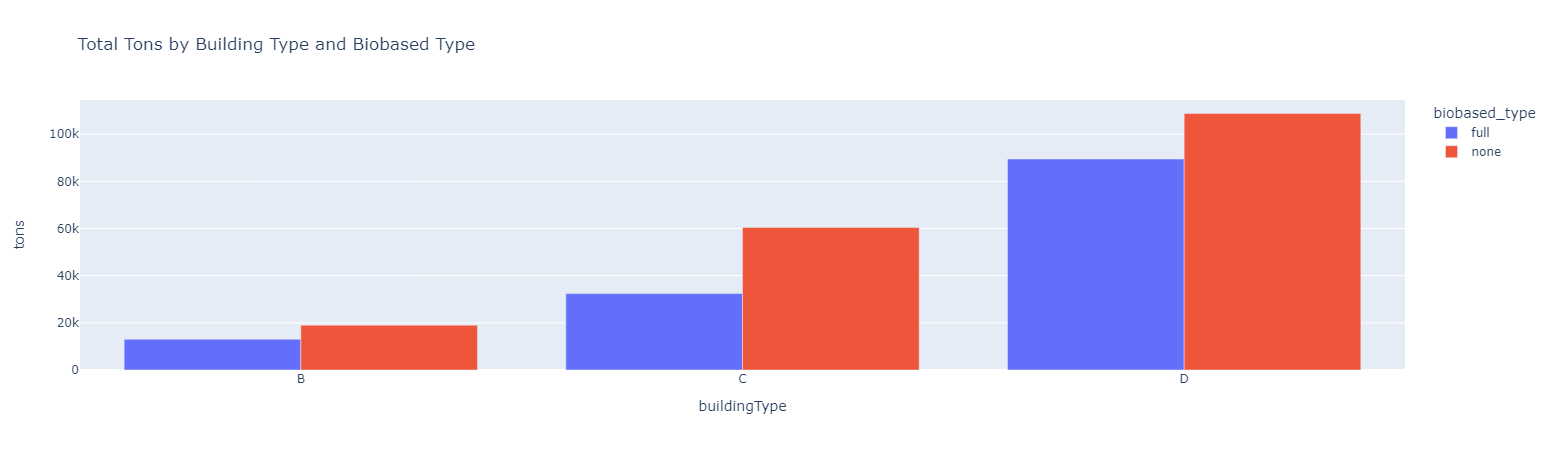

In [46]:
df = pd.read_csv('data/data_cleaned/buildingType_info.csv')
df = df[~df.tons.isna()]

grouped_data = df.groupby(['buildingType', 'biobased_type']).sum(numeric_only=True).reset_index()

fig = px.bar(grouped_data, x='buildingType', y='tons', color='biobased_type', barmode='group',
             title='Total Tons by Building Type and Biobased Type')
fig.update_layout(width=600, autosize=False)
fig.show()

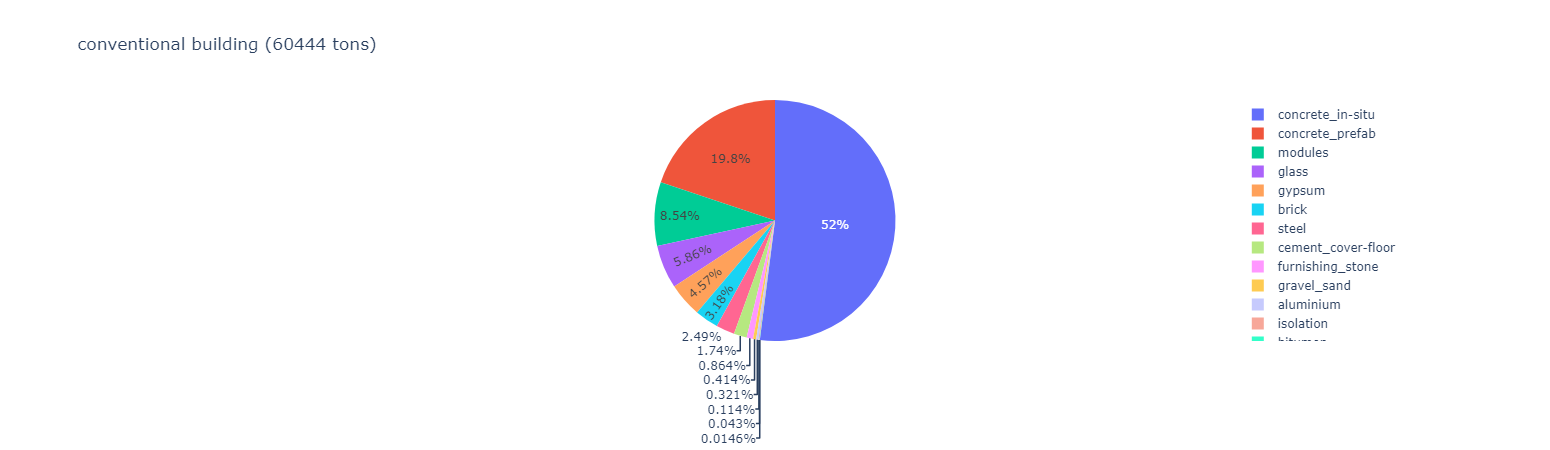

In [38]:
df = pd.read_csv('data/data_cleaned/buildingType_info.csv')
df = df[(df.buildingType == 'C') & (df.biobased_type == 'none')]
df = df[~df.tons.isna()]
mass_total = df.tons.sum()
df

fig = px.pie(df, values='tons', names='material', title=f'conventional building ({round(mass_total)} tons)')
fig.update_layout(width=700, autosize=False)
fig.show()

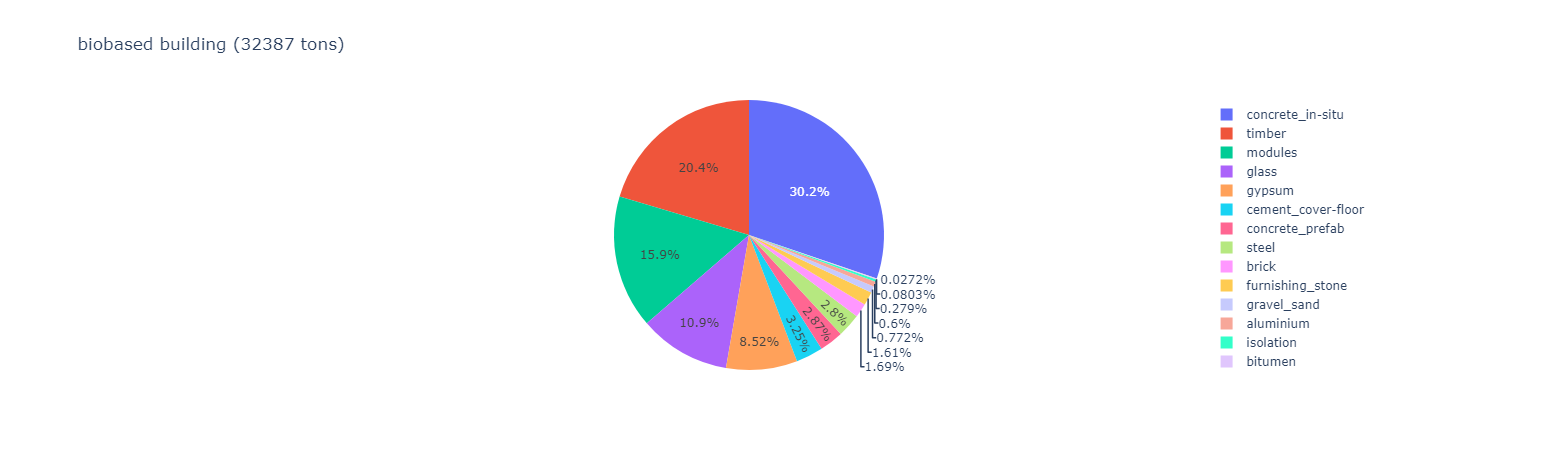

In [39]:
df = pd.read_csv('data/data_cleaned/buildingType_info.csv')
df = df[(df.buildingType == 'C') & (df.biobased_type == 'full')]
df = df[~df.tons.isna()]
mass_total = df.tons.sum()
df

fig = px.pie(df, values='tons', names='material', title=f'biobased building ({round(mass_total)} tons)')
fig.update_layout(width=700, autosize=False)
fig.show()

In [98]:
railPaths_plot = gpd.read_file('data/networkLines_rail.gpkg')
waterPaths_plot = gpd.read_file('data/networkLines_water.gpkg') 

m = folium.Map([52.377231, 4.899288], zoom_start=11, tiles='cartodbdark_matter')

def style_function(feature):
    return {
        'color': 'blue',
        'weight': 2,
        'opacity': 1,
    }

folium.GeoJson(
    waterPaths_plot,
    style_function=style_function,
).add_to(m)

m

In [90]:
site = [s for s in model.construction_sites][0]
df = site.material_composition_df
circularity_type = model.circularity_type

circularity_dict = {
            'none': [], 
            'semi': ['non-structural'], 
            'full': ['non-structural', 'structural'], 
            'extreme': ['non-structural', 'structural', 'foundation']
        }

def decide_circularity(row): 
    bulk_materials = ['cement_cover-floor', 'concrete_in-situ', 'concrete_prefab', 'gravel_sand']
    row['circular'] = 'circular' if row.structural_type in circularity_dict[circularity_type] else 'not circular'
    if row.material in bulk_materials or row.material == 'modules': 
        row['circular'] = 'not circular'
    return row 
df = df.apply(lambda row: decide_circularity(row), axis=1)
# df = df.groupby('circular').sum(numeric_only=True).reset_index()
df

,material,unit,biobased_type,structural_type,buildingType,tons,circular
46,concrete_in-situ,tons,full,foundation,B,2652.00000,not circular
50,gravel_sand,tons,full,foundation,B,200.00000,not circular
55,steel,tons,full,foundation,B,221.00000,not circular
85,modules,tons,full,non-structural,B,3439.00000,not circular
60,concrete_in-situ,tons,full,structural,B,275.58360,not circular
61,concrete_prefab,tons,full,structural,B,2941.96254,not circular
69,steel,tons,full,structural,B,39.85650,circular


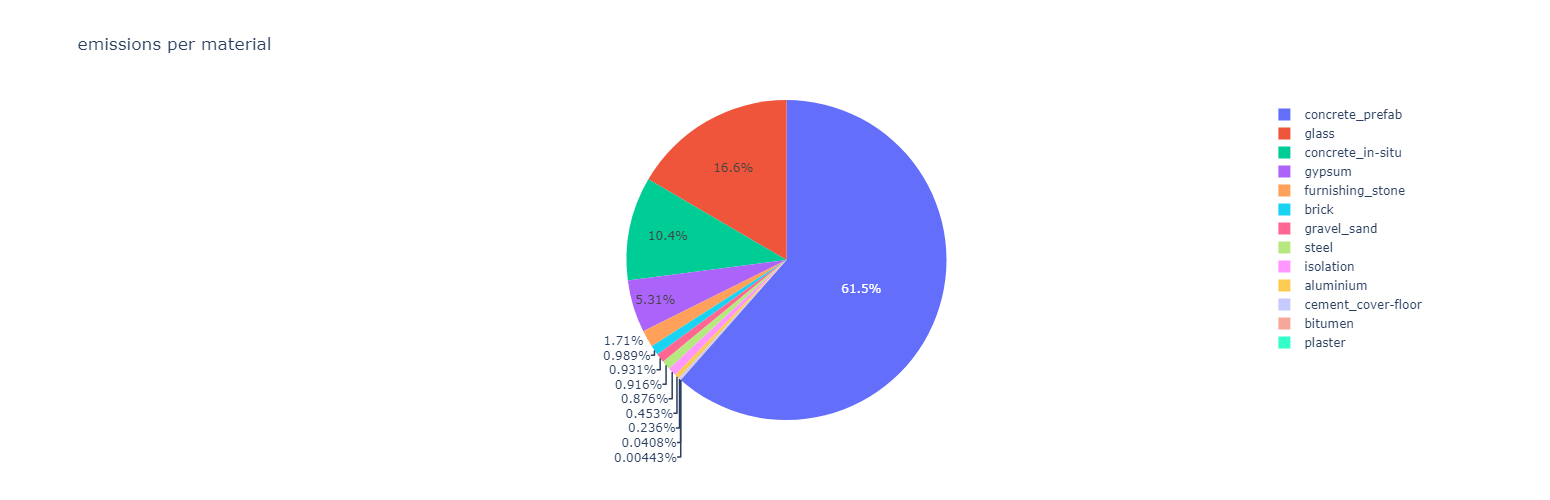

In [185]:
data = model.datacollector.get_model_vars_dataframe()
df = data.copy()
df = df[['emissions_per_material']]
df = df.explode('emissions_per_material').reset_index(names='step')
df = df.rename(columns={'emissions_per_material': 'material'})
df = df.dropna()
def get_emissions(row): 
    emissions_dict = data.iloc[row.step].emissions_per_material
    row['emissions'] = emissions_dict[row.material]
    return row
df = df.apply(lambda row: get_emissions(row), axis=1)

dfAdd = df[df.step == 1]
dfAdd.step = 0
dfAdd.emissions = 0
df = pd.concat([dfAdd, df])
df.step = df.step.map(lambda x: x + 2023)
df.rename(columns={'step': 'year'}, inplace=True)

df = df[df.year == 2028]
df

fig = px.pie(df, values='emissions', names='material', title='emissions per material', height=500, width=500)
fig.show()

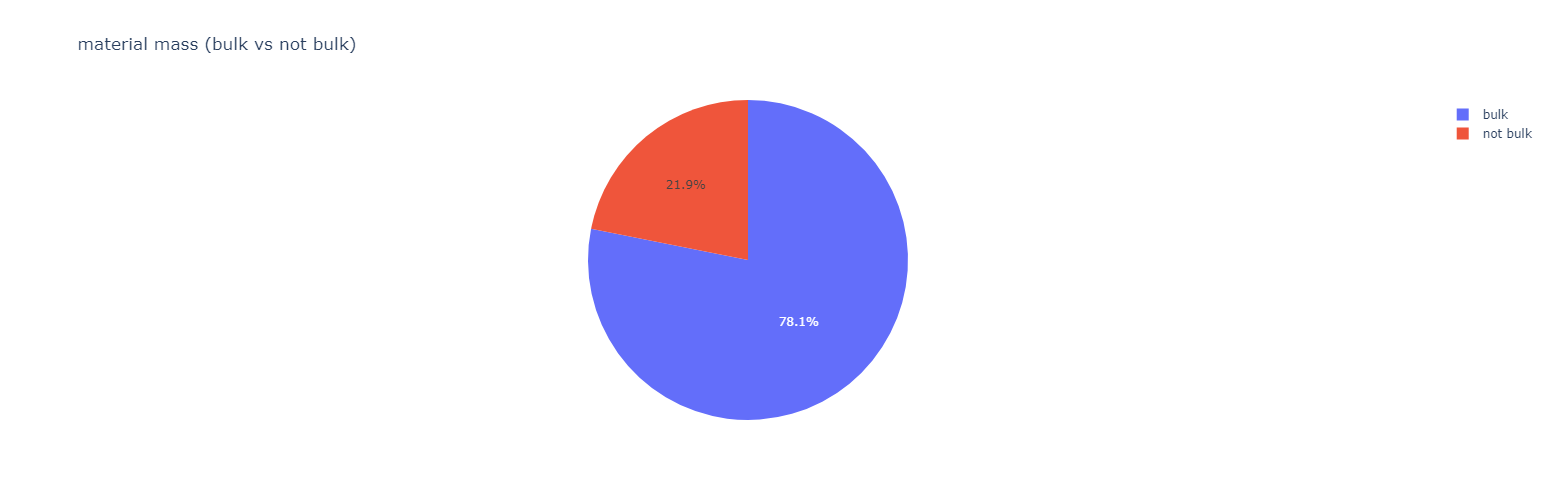

In [100]:
df = model.build_info
df = df[(df.biobased_type == 'none') & (df.material != 'modules')]
df['bulk'] = df.material.map(lambda x: 'bulk' if x in ['cement_cover-floor', 'concrete_in-situ', 'concrete_prefab', 'gravel_sand'] else 'not bulk')
df = df[~df.tons.isna()]
df

fig = px.pie(df, values='tons', names='bulk', title='material mass (bulk vs not bulk)', height=500, width=500)
fig.show()

In [70]:
df = model.build_info
df = df[(df.biobased_type == 'none') & (df.buildingType == 'B') & (df.material != 'modules')]
def decide_collectFrom(row):
    circular_strucTypes = ['structural', 'non-structural', 'foundation']
    row['collectFrom'] = 'from demSites' if row.structural_type in circular_strucTypes else 'from suppliers'
    if row.material in ['cement_cover-floor', 'concrete_in-situ', 'concrete_prefab', 'gravel_sand']: 
        row['collectFrom'] = 'from suppliers' 
    return row 
df = df.apply(lambda row: decide_collectFrom(row), axis=1)
df = df[~df.tons.isna()]
df

,material,unit,biobased_type,structural_type,buildingType,tons,collectFrom
3,concrete_in-situ,tons,none,foundation,B,2652.0000,from suppliers
7,gravel_sand,tons,none,foundation,B,200.0000,from suppliers
12,steel,tons,none,foundation,B,221.0000,from demSites
17,concrete_in-situ,tons,none,structural,B,547.2000,from suppliers
18,concrete_prefab,tons,none,structural,B,7816.0000,from suppliers
26,steel,tons,none,structural,B,199.2825,from demSites
28,aluminium,tons,none,non-structural,B,321.0000,from demSites
29,brick,tons,none,non-structural,B,322.0000,from demSites
32,concrete_prefab,tons,none,non-structural,B,723.8000,from suppliers
33,furnishing_stone,tons,none,non-structural,B,216.0000,from demSites


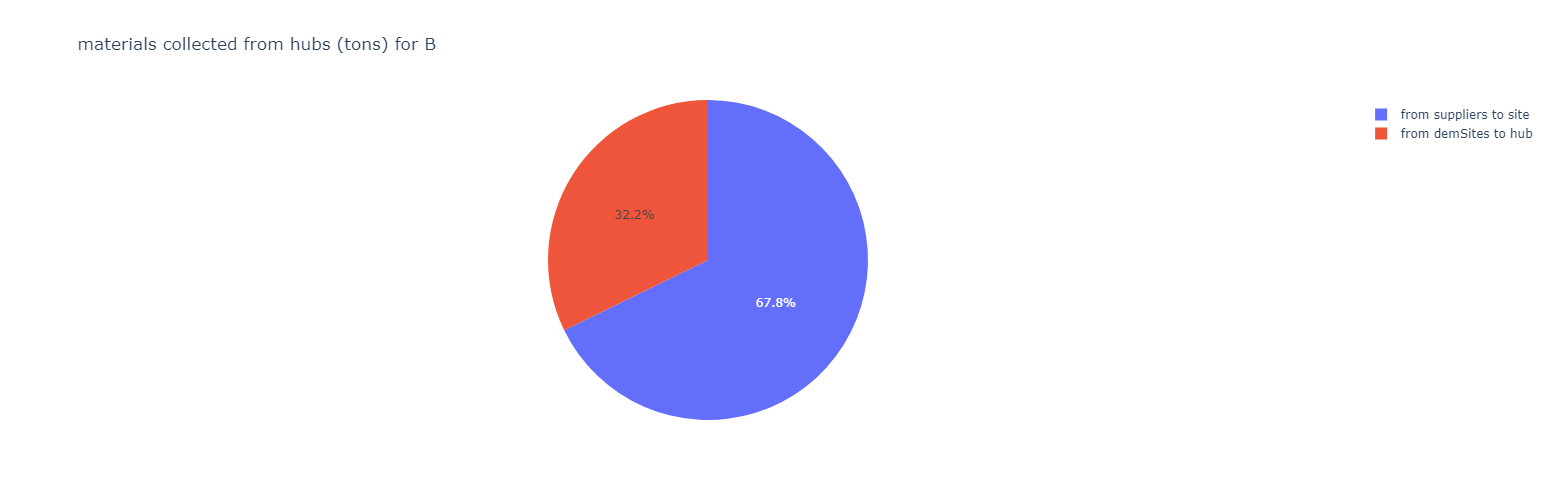

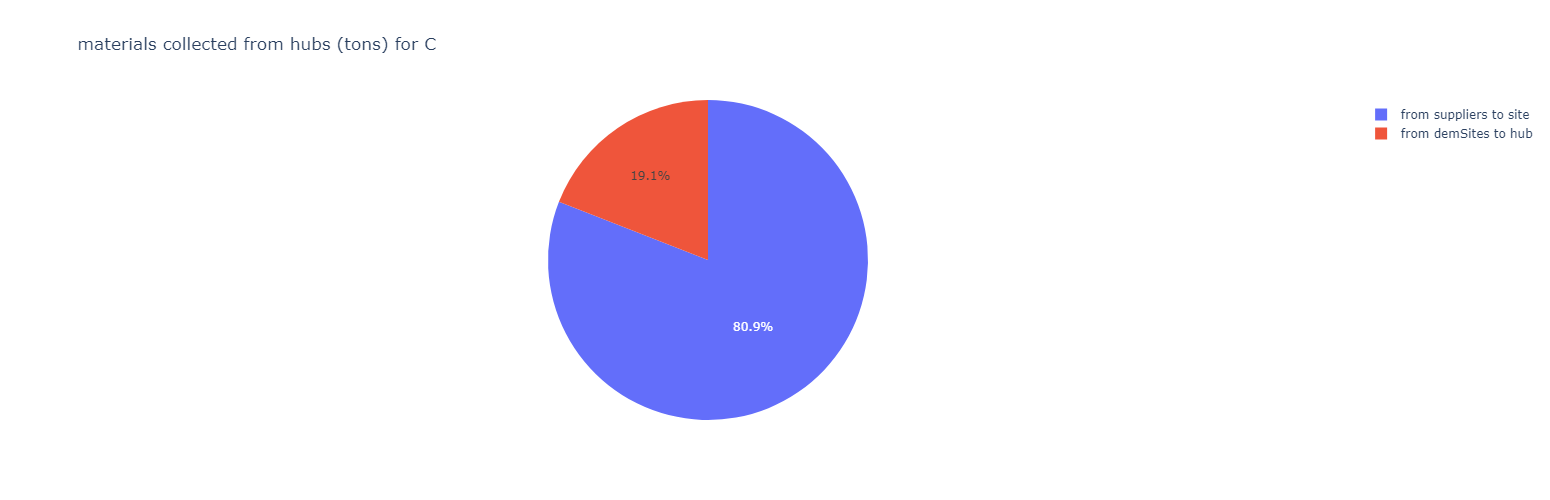

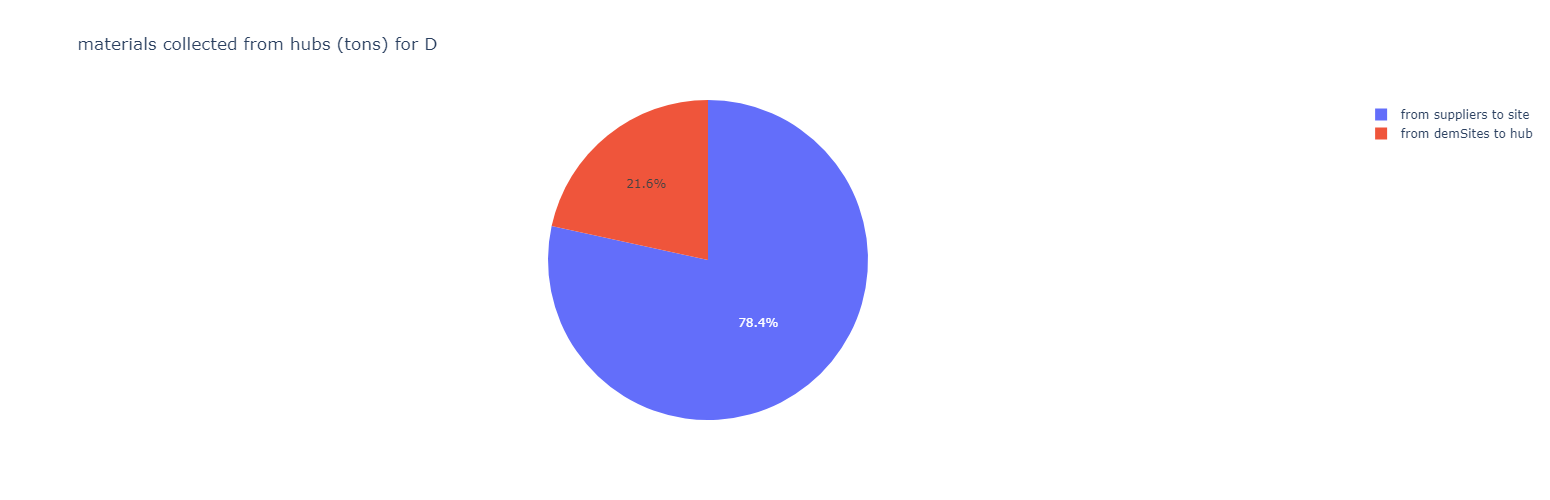

In [77]:
def make_collecFrom_df(buildingType): 
    df = model.build_info
    df = df[(df.biobased_type == 'none') & (df.buildingType == buildingType) & (df.material != 'modules')]
    def decide_collectFrom(row):
        circular_strucTypes = ['structural', 'non-structural', 'foundation']
        row['collectFrom'] = 'from demSites to hub' if row.structural_type in circular_strucTypes else 'from suppliers to hub'
        if row.material in ['cement_cover-floor', 'concrete_in-situ', 'concrete_prefab', 'gravel_sand']: 
            row['collectFrom'] = 'from suppliers to site' 
        return row 
    df = df.apply(lambda row: decide_collectFrom(row), axis=1)
    df = df[~df.tons.isna()]
    return df

buildingType = 'B'
for buildingType in ['B', 'C', 'D']: 
    df = make_collecFrom_df(buildingType)
    fig = px.pie(df, values='tons', names='collectFrom', title=f'materials collected from hubs (tons) for {buildingType}', height=500, width=500)
    fig.show()

In [10]:
# def test_run(): 
#     parameters_dict = {}
#     for name in dropdowns.keys(): 
#         parameters_dict[name] = dropdowns[name].value

#     for key, value in parameters_dict.items():
#         if key in params_conversion:
#             parameters_dict[key] = params_conversion[key][value]

#     # create and run model 
#     model = Model(parameters_dict)
#     for i in range(10): 
#         model.step()

#     emissions_text, fig_emissions, fig_materials, map_html = model.visualize()

#     # visualize as widgets
#     print(emissions_text)

#     fig_widget_emissions = widgets.Output(layout=widgets.Layout())
#     fig_widget_materials = widgets.Output(layout=widgets.Layout()) 
#     with fig_widget_emissions:
#         fig_emissions.show()
#     with fig_widget_materials: 
#         fig_materials.show()

#     v_box = widgets.VBox([fig_widget_emissions, fig_widget_materials], layout=widgets.Layout(width='30%', height='600px'))

#     map_widget = widgets.HTML(map_html, layout=widgets.Layout(width='70%'))
#     h_box = widgets.HBox([v_box, map_widget])
#     display(h_box)

In [9]:
# %%time
# def profiled_run():
#     test_run()
# profiler = cProfile.Profile()
# profiler.enable()
# profiled_run()  # This will run the on_button_clicked function.
# profiler.disable()
# profiler.dump_stats("profile_results.prof")
# profiler.print_stats()

In [1]:
# # export for casper and eric 

# # folium map
# # roads used
# roads_used = model.roads_used
# # demolition sites
# demolition_sites = model.demolition_sites_df
# # hubs (macro only for now)
# hubs = gpd.read_file('data/data_cleaned/hubs.shp')
# # construction sites 
# construction_sites = gpd.read_file('data/data_cleaned/construction_sites.shp')
# # suppliers
# suppliers = gpd.read_file('data/data_cleaned/suppliers.shp')

# # emissions chart 
# # csv of emissions over time 
# emissions = model.datacollector.get_model_vars_dataframe()

# # materials chart
# # csv of materials used 
# df_materials_byType = model.df_mat
# # csv of circular materials used 
# df_materials_byCirc = model.df_circ

# # folium map
# roads_used.to_file('results/folium_roadsUsed.shp')
# demolition_sites.to_file('results/folium_demolitionSites.shp')
# construction_sites.to_file('results/folium_constructionSites.shp')
# hubs.to_file('results/folium_hubs.shp')
# suppliers.to_file('results/folium_suppliers.shp')

# # charts
# emissions.to_csv('results/chart_line_emissions.csv')
# df_materials_byType.to_csv('results/charts__pie_materialsByType.csv')
# df_materials_byCirc.to_csv('results/charts_pie_materialsByCircularity.csv')